In [34]:
from typing import Any
import numpy as np
import random

class RandomWalk:
    def __init__(self) -> None:
        self.state = 2
        pass
    
    def action_space(self):
        return 2
    
    def state_space(self):
        return 5
    
    def reset(self):
        self.state = 2
        return self.state
    
    def step_(self, action):
        new_state = self.state + (-1 if action == 0 else 1)
        reward = 1 if new_state == 5 else 0
        terminated = new_state == -1 or new_state == 5
        self.state = 2 if terminated else new_state
        return terminated, reward, new_state
    
    def step(self):
        return self.step_(random.choice(range(2)))
        
def td0_evaluating_state_values(env, num_episodes, alpha, gamma = 1.0, callback = None):
    num_states = env.state_space()
    num_actions = env.action_space()
    values = np.full(num_states,0.5,dtype=float)
    for episode in range(num_episodes):
        state = env.reset()
        while True:
            terminated, reward, new_state = env.step()
            v_prime = 0 if terminated else values[new_state]
            values[state] += (reward + gamma * v_prime - values[state]) * alpha
            state = new_state
            if terminated:
                break
        if callback:
            callback(values)
    return values

def montecaro_evaluating_state_values(env, num_episodes, alpha, gamma = 1.0, callback = None):
    num_states = env.state_space()
    num_actions = env.action_space()
    values = np.full(num_states,0.5,dtype=float)
    for episode in range(num_episodes):
        states=[]
        rewards=[]
        state = env.reset()
        while True:
            terminated, reward, new_state = env.step()
            states.append(state)
            rewards.append(reward)
            state = new_state
            if terminated:
                break
        episode_len = len(rewards)
        g = 0
        #v_prime = 0 #test reversed td  
        for t in range(episode_len-1,-1,-1):
            state = states[t]
            reward = rewards[t]
            g = reward + g * gamma
            values[state] += (g - values[state]) * alpha
            #values[state] += (reward + gamma * v_prime - values[state]) * alpha
            #v_prime = values[state]
        if callback:
            callback(values)
    return values

class CalcError:
    def __init__(self, num_states, mses):
        self.true_values = np.zeros(num_states, dtype=float)
        self.true_values[:] = [float(n+1)/(num_states+1) for n in range(num_states)]
        self.mses = mses

    def calc_mse(self, values):
        return np.power(self.true_values - values, 2).mean()
    
    def __call__(self, values):
        self.mses.append(self.calc_mse(values))


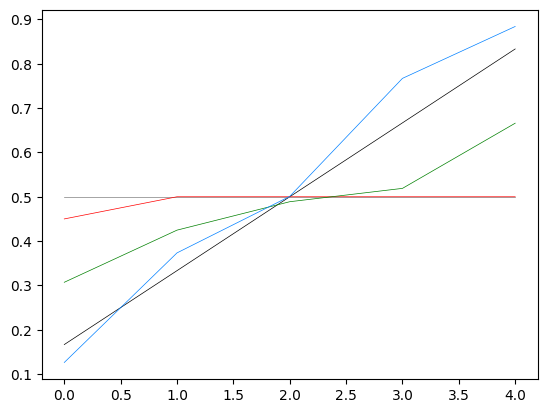

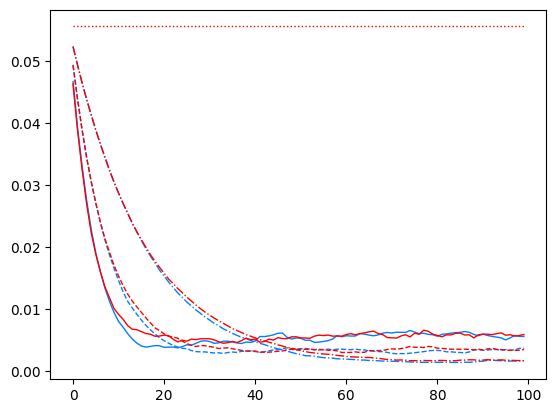

In [37]:
import matplotlib.pyplot as plt
env = RandomWalk()
num_states = env.state_space()
true_values = [float(n+1)/(num_states+1) for n in range(num_states)]
plt.plot(range(num_states), true_values, "#000000", linewidth = 0.5)

episodes=[0,1,10,100]
colors = ["#808080", "#FF0000", "#008000", "#0080FF"]
for n,c in zip(episodes,colors):
    values = td0_evaluating_state_values(env, n, 0.1)
    plt.plot(range(num_states), values, c, linewidth = 0.5)
plt.show()


params = [
    [td0_evaluating_state_values, 0.15, "-", "#0080FF"],
    [td0_evaluating_state_values, 0.10, "--", "#0080FF"],
    [td0_evaluating_state_values, 0.05, "-.", "#0080FF"],
    [montecaro_evaluating_state_values, 0.04, "-", "#FF0000"],
    [montecaro_evaluating_state_values, 0.03, "--", "#FF0000"],
    [montecaro_evaluating_state_values, 0.02, "-.", "#FF0000"],
    [montecaro_evaluating_state_values, 0.01, ":", "#FF0000"],
]

num_episodes = 100
for param in params:
    mmse = np.zeros(num_episodes,dtype=float)
    for n in range(100):
        mses = []
        calc_error = CalcError(num_states, mses)
        param[0](env, num_episodes, param[1], callback=calc_error)
        mmse[:] += mses
    mmse /= 100
    plt.plot(range(num_episodes), mmse, param[2], color=param[3], linewidth = 1)




In [29]:
plt.plot?

Signature: plt.plot(*args, scalex=True, scaley=True, data=None, **kwargs)
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], *, data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yield identical results:

>>> plot(x, y, 'go--', linewidth=2, markersize=12)
>>> plot(x, y,